In [1]:
# 1 - SETUP Y DEPENDENCIAS
# ------------------------------------------------------------
# - Importa librerías
# - Fija semilla y dispositivo
# - Parámetros globales del problema (adimensionales)
# ------------------------------------------------------------

import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Reproducibilidad y dispositivo
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device( "cuda:3" if torch.cuda.is_available() else "cpu" )
torch.set_default_dtype(torch.float64)

# Parámetros físicos adimensionales
@dataclass
class Params:
    zeta: float = 0.05     # amortiguamiento adimensional
    kappa: float = 0.30    # acoplamiento adimensional (kc/k)
    A1: float = 1.0        # amplitud de F1(t) = A1 cos(omega t)
    A2: float = 0.6        # amplitud de F2(t) = A2 sin(omega t)
    omega: float = 1.3     # frecuencia adimensional de forzado

P = Params()

# Rango temporal y muestreo
N_PERIODS = 12
T_forzado = 2.0*math.pi/P.omega
t_ini, t_fin = 0.0, N_PERIODS*T_forzado

# Condiciones iniciales (transitorio; la PINN las usará)
x10, v10 = 0.0, 0.0
x20, v20 = 0.0, 0.0

# Muestreo de entrenamiento y evaluación
N_COL = 4000    # puntos de collocation (física)
N_IC  = 64      # puntos en t=0 para IC
USE_PERIODICITY = True     # imponemos x(t)~x(t+T) si se quiere régimen estacionario
N_PB  = 256     # puntos para periodicidad

# Fourier features
USE_FOURIER = True
N_HARMONICS = 6   # número de armónicos (1..N) de la frecuencia omega

# Entrenamiento
LR = 1e-3
EPOCHS = 4000
PRINT_EACH = 200
USE_LBFGS = True  # refinamiento final tipo PINN clásico

# Pesos de pérdidas
W_PHYS = 3.0
W_IC   = 5.0
W_PB   = 1.0

# Resolución de curvas
N_EVAL = 1200  # puntos para graficar curvas


In [2]:
# 2 - SOLUCIÓN ANALÍTICA (RÉGIMEN ESTACIONARIO) + IC CONSISTENTES
# ------------------------------------------------------------
# Respuesta estacionaria EXACTA para:
#   x'' + 2ζ x' + K x = g(t),  K = [[1+κ, -κ], [-κ, 1+κ]]
#   g(t) = [A1 cos(ω t), A2 sin(ω t)]
# En notación compleja:
#   (K - ω^2 I + i 2ζ ω I) X = G,  con G = [A1, -i A2]
# De donde:
#   x(t) = Re{X} cos(ωt) - Im{X} sin(ωt)
#   v(t) = -ω[ Re{X} sin(ωt) + Im{X} cos(ωt) ]
# En t=0:
#   x(0) = Re{X},  v(0) = -ω Im{X}
# ------------------------------------------------------------

import numpy as np
from typing import Tuple

def analytic_amplitudes(zeta: float, kappa: float, A1: float, A2: float, omega: float) -> np.ndarray:
    """Devuelve X = [X1, X2] (complejos) tal que (K - ω^2 I + i 2ζ ω I) X = G."""
    K = np.array([[1.0+kappa, -kappa],
                  [-kappa, 1.0+kappa]], dtype=np.complex128)
    I = np.eye(2, dtype=np.complex128)
    D = K - (omega**2)*I + 1j*2.0*zeta*omega*I  # rigidez dinámica compleja
    G = np.array([A1, -1j*A2], dtype=np.complex128)  # fuerzas complejas
    X = np.linalg.solve(D, G)  # [X1, X2]
    return X

def analytic_steady_state(t: np.ndarray, zeta: float, kappa: float, A1: float, A2: float, omega: float) -> Tuple[np.ndarray, np.ndarray]:
    """x1(t), x2(t) estacionarios (sin transitorio) a partir de X."""
    X = analytic_amplitudes(zeta, kappa, A1, A2, omega)
    Xr = X.real; Xi = X.imag
    cosw = np.cos(omega*t)
    sinw = np.sin(omega*t)
    x1 = Xr[0]*cosw - Xi[0]*sinw
    x2 = Xr[1]*cosw - Xi[1]*sinw
    return x1, x2

# --- Datos “reales” estacionarios en la rejilla t_eval ---
t_eval = np.linspace(t_ini, t_fin, N_EVAL)
x1_real, x2_real = analytic_steady_state(t_eval, P.zeta, P.kappa, P.A1, P.A2, P.omega)

# --- Ajuste de CONDICIONES INICIALES para que cuadren con la analítica ---
X = analytic_amplitudes(P.zeta, P.kappa, P.A1, P.A2, P.omega)
# En t=0: x(0)=Re{X}, v(0)=-ω Im{X}
x10 = float(X.real[0]); v10 = float(-P.omega * X.imag[0])
x20 = float(X.real[1]); v20 = float(-P.omega * X.imag[1])

# (Opcional) Comprobación rápida
print("IC ajustadas al estacionario:")
print(f"x1(0)={x10:.6f}  v1(0)={v10:.6f} | x2(0)={x20:.6f}  v2(0)={v20:.6f}")
print("Chequeo con curvas analíticas en t=0:")
print(f"x1_real[0]-x10 = {x1_real[0]-x10:+.3e}   x2_real[0]-x20 = {x2_real[0]-x20:+.3e}")


IC ajustadas al estacionario:
x1(0)=-1.018905  v1(0)=4.409558 | x2(0)=-0.538905  v2(0)=-5.158442
Chequeo con curvas analíticas en t=0:
x1_real[0]-x10 = +0.000e+00   x2_real[0]-x20 = +0.000e+00


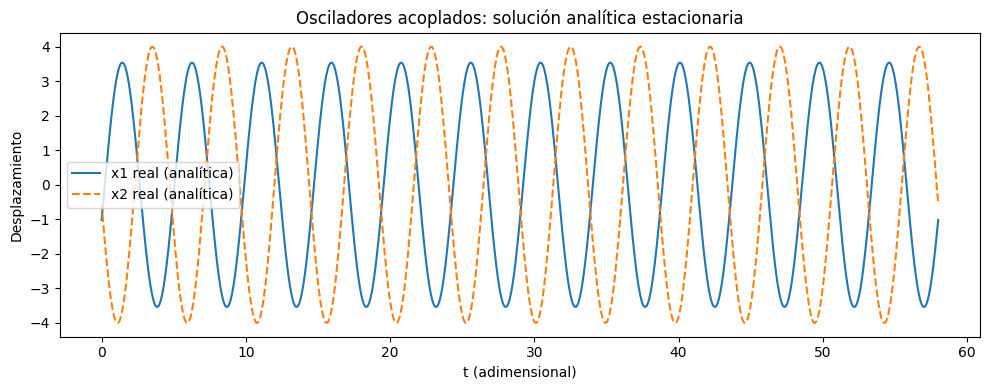

In [3]:
# 3 - GRÁFICA: DATOS REALES (ANALÍTICOS)
# ------------------------------------------------------------
# Dibuja x1(t) y x2(t) estacionarios para inspección visual.
# ------------------------------------------------------------

plt.figure(figsize=(10,4))
plt.plot(t_eval, x1_real, label="x1 real (analítica)")
plt.plot(t_eval, x2_real, label="x2 real (analítica)", linestyle="--")
plt.xlabel("t (adimensional)")
plt.ylabel("Desplazamiento")
plt.title("Osciladores acoplados: solución analítica estacionaria")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# 4 - PINN CON FOURIER FEATURES (DEFINICIONES)
# ------------------------------------------------------------
# - Codificador de tiempo con Fourier features
# - MLP flexible
# - Utilidades de derivadas, fuerzas, muestreo
# - Residuos físicos que aceptan modelo y codificador externos
# ------------------------------------------------------------
class FourierFeatures(nn.Module):
    def __init__(self, omega: float, n_harmonics: int):
        super().__init__()
        self.omega = omega
        self.n = n_harmonics

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        feats = [t]
        for n in range(1, self.n+1):
            feats.append(torch.sin(n*self.omega*t))
            feats.append(torch.cos(n*self.omega*t))
        return torch.cat(feats, dim=1)

class MLP(nn.Module):
    def __init__(self, n_in: int, n_out: int = 2, width: int = 128, depth: int = 5, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(n_in, width), act()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act()]
        layers += [nn.Linear(width, n_out)]
        self.net = nn.Sequential(*layers)
        self.apply(self._init)

    @staticmethod
    def _init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# Construcción helpers
def build_ff(omega: float, n_harmonics: int, use_fourier: bool):
    if not use_fourier:
        return None
    return FourierFeatures(omega, n_harmonics).to(device)

def build_model(n_in: int, width: int, depth: int, act=nn.Tanh):
    return MLP(n_in=n_in, n_out=2, width=width, depth=depth, act=act).to(device)

def encode_time(ff, t: torch.Tensor) -> torch.Tensor:
    return ff(t) if ff is not None else t

# Derivadas
def ddt(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0]

def ddtt(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    dy = ddt(y, t)
    return torch.autograd.grad(dy, t, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True)[0]

# Fuerza g(t) = [A1 cos(ωt), A2 sin(ωt)]
def g_batch(t: torch.Tensor, A1: float, A2: float, omega: float) -> torch.Tensor:
    g1 = A1*torch.cos(omega*t)
    g2 = A2*torch.sin(omega*t)
    return torch.cat([g1, g2], dim=1)

# Muestras
def sample_collocation(n: int) -> torch.Tensor:
    return (torch.rand(n,1, device=device)*(t_fin - t_ini) + t_ini).requires_grad_(True)

def sample_ic(n: int) -> torch.Tensor:
    return torch.zeros(n,1, device=device, requires_grad=True)

def sample_periodic(n: int) -> Tuple[torch.Tensor, torch.Tensor]:
    tA = (torch.rand(n,1, device=device)*(t_fin - t_ini - T_forzado) + t_ini).requires_grad_(True)
    tB = (tA + T_forzado).requires_grad_(True)
    return tA, tB

# Residuos físicos (general, acepta modelo y ff externos)
def physics_residuals(t: torch.Tensor, model: nn.Module, ff, zeta: float, kappa: float, A1: float, A2: float, omega: float):
    xin = encode_time(ff, t)
    x = model(xin)                  # (N,2) -> x1, x2
    x1, x2 = x[:,0:1], x[:,1:2]
    x1_t = ddt(x1, t); x2_t = ddt(x2, t)
    x1_tt = ddtt(x1, t); x2_tt = ddtt(x2, t)

    g = g_batch(t, A1, A2, omega)
    g1, g2 = g[:,0:1], g[:,1:2]

    # K = [[1+κ, -κ], [-κ, 1+κ]]
    r1 = x1_tt + 2*zeta*x1_t + (1+kappa)*x1 - kappa*x2 - g1
    r2 = x2_tt + 2*zeta*x2_t + (1+kappa)*x2 - kappa*x1 - g2
    return r1, r2, x1, x2, x1_t, x2_t


In [5]:
# 5 - PÉRDIDAS Y ENTRENAMIENTO (UTILIDADES)  [con tqdm]
# ------------------------------------------------------------
# - Define la loss total: física + IC (+ periodicidad opcional)
# - Función de entrenamiento reusable (Adam + opcional LBFGS)
# - Añade barras de progreso con tqdm (por época)
# ------------------------------------------------------------
from typing import Optional
from copy import deepcopy
import time
from tqdm.notebook import tqdm   # <-- NUEVO

def loss_total(model: nn.Module, ff, use_periodicity: bool,
               n_col: int, n_ic: int, n_pb: int,
               w_phys: float, w_ic: float, w_pb: float):
    # Física
    t_col = sample_collocation(n_col)
    r1, r2, _, _, _, _ = physics_residuals(t_col, model, ff, P.zeta, P.kappa, P.A1, P.A2, P.omega)
    L_phys = (r1**2).mean() + (r2**2).mean()

    # ICs en t=0
    t0 = sample_ic(n_ic)
    _, _, x1_0_hat, x2_0_hat, v1_0_hat, v2_0_hat = physics_residuals(t0, model, ff, P.zeta, P.kappa, P.A1, P.A2, P.omega)
    L_ic = ((x1_0_hat - x10)**2).mean() + ((x2_0_hat - x20)**2).mean() \
         + ((v1_0_hat - v10)**2).mean() + ((v2_0_hat - v20)**2).mean()

    # Periodicidad (opcional)
    L_per = torch.tensor(0.0, device=device)
    if use_periodicity:
        tA, tB = sample_periodic(n_pb)
        xA = model(encode_time(ff, tA))
        xB = model(encode_time(ff, tB))
        dA = ddt(xA, tA)
        dB = ddt(xB, tB)
        L_per = ((xA - xB)**2).mean() + ((dA - dB)**2).mean()

    L = w_phys*L_phys + w_ic*L_ic + (w_pb*L_per if use_periodicity else 0.0)
    logs = {"phys": L_phys.item(), "ic": L_ic.item(), "per": (L_per.item() if use_periodicity else 0.0)}
    return L, logs

def train_run(width=128, depth=5, n_harmonics=6, use_fourier=True, use_periodicity=True,
              lr=1e-3, epochs=2000, print_each=200,
              n_col=4000, n_ic=64, n_pb=256, w_phys=1.0, w_ic=5.0, w_pb=1.0, use_lbfgs=True,
              seed=1234, save_checkpoints=False,
              show_epoch_bar=True, epoch_bar_desc=None):   # <-- NUEVOS parámetros
    # Semillas
    np.random.seed(seed); torch.manual_seed(seed)

    # Entrada
    n_in = 1 + (2*n_harmonics if use_fourier else 0)
    ff = build_ff(P.omega, n_harmonics, use_fourier)
    model = build_model(n_in, width=width, depth=depth)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"total": [], "phys": [], "ic": [], "per": []}
    checkpoints = []  # (epoch, x1, x2) sobre rejilla
    t_grid = torch.linspace(t_ini, t_fin, N_EVAL, device=device).view(-1,1).requires_grad_(True)

    t0_run = time.time()

    epoch_iter = range(1, epochs+1)
    if show_epoch_bar:
        epoch_iter = tqdm(epoch_iter, total=epochs, leave=True,
                          desc=epoch_bar_desc or "Entrenamiento")

    for epoch in epoch_iter:
        optimizer.zero_grad()
        L, logs = loss_total(model, ff, use_periodicity, n_col, n_ic, n_pb, w_phys, w_ic, w_pb)
        L.backward()
        optimizer.step()

        history["total"].append(L.item())
        history["phys"].append(logs["phys"])
        history["ic"].append(logs["ic"])
        history["per"].append(logs["per"])

        if show_epoch_bar:
            # mostrar métricas compactas
            epoch_iter.set_postfix(loss=float(L.item()), phys=float(logs["phys"]), ic=float(logs["ic"]))

        if save_checkpoints and (epoch % print_each == 0 or epoch == 1):
            with torch.no_grad():
                x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
            checkpoints.append((epoch, x_hat[:,0].copy(), x_hat[:,1].copy()))

    if use_lbfgs:
        def closure():
            optimizer_lbfgs.zero_grad()
            Lc, _ = loss_total(model, ff, use_periodicity, n_col, n_ic, n_pb, w_phys, w_ic, w_pb)
            Lc.backward()
            return Lc
        optimizer_lbfgs = optim.LBFGS(model.parameters(), max_iter=500,
                                      tolerance_grad=1e-9, tolerance_change=1e-12,
                                      line_search_fn="strong_wolfe")
        L_final = optimizer_lbfgs.step(closure).item()
        history["total"].append(L_final)
        if save_checkpoints:
            with torch.no_grad():
                x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
            checkpoints.append((epochs+999, x_hat[:,0].copy(), x_hat[:,1].copy()))

    # Métrica MSE vs analítica (estacionaria)
    with torch.no_grad():
        x_hat = model(encode_time(ff, t_grid)).detach().cpu().numpy()
    t_eval_local = t_grid.detach().cpu().numpy().squeeze()
    x1r, x2r = analytic_steady_state(t_eval_local, P.zeta, P.kappa, P.A1, P.A2, P.omega)
    val_mse = float(np.mean((x_hat[:,0]-x1r)**2 + (x_hat[:,1]-x2r)**2))

    state = deepcopy(model.state_dict())
    elapsed = time.time()-t0_run
    meta = {"width": width, "depth": depth, "n_harmonics": n_harmonics, "use_fourier": use_fourier,
            "use_periodicity": use_periodicity, "lr": lr, "epochs": epochs, "seed": seed,
            "n_col": n_col, "n_ic": n_ic, "n_pb": n_pb, "use_lbfgs": use_lbfgs, "elapsed_sec": elapsed}

    return model, ff, state, history, checkpoints, val_mse, meta


In [17]:
# 6 - GRID SEARCH: espacio de búsqueda y ejecución  [actualizado]
# ------------------------------------------------------------
# - 8 arquitecturas (añadimos 4 más)
# - HPs con n_harmonics=2..6 y nombres HP_[LETRA]_[CONFIG]
# - 4 configs por letra:
#     1: no periodicidad, sin LBFGS
#     2: no periodicidad, con LBFGS
#     3: con periodicidad, con LBFGS
#     4: con periodicidad, sin LBFGS   (la pedida explícitamente)
# - Barra de progreso global + barra por época (desde Celda 5)
# ------------------------------------------------------------
import pandas as pd
from tqdm.notebook import tqdm

# Arquitecturas (4 originales + 4 nuevas)
architectures = [
    {"name":"MLP_w64_d3",   "width":64,  "depth":3},
    {"name":"MLP_w128_d4",  "width":128, "depth":4},
    {"name":"MLP_w128_d6",  "width":128, "depth":6},
    {"name":"MLP_w256_d4",  "width":256, "depth":4},
    # ---- 4 nuevas ----
    {"name":"MLP_w64_d6",   "width":64,  "depth":6},
    {"name":"MLP_w96_d5",   "width":96,  "depth":5},
    {"name":"MLP_w160_d5",  "width":160, "depth":5},
    {"name":"MLP_w256_d6",  "width":256, "depth":6},
]

def build_hp_grid():
    """
    Letras A..E con mapeo:
      A: lr=2e-3, epochs=1500, n_harmonics=2
      B: lr=1e-3, epochs=2000, n_harmonics=3
      C: lr=7e-4, epochs=2500, n_harmonics=4
      D: lr=5e-4, epochs=3000, n_harmonics=5
      E: lr=3e-4, epochs=4000, n_harmonics=6   # hiperparámetros más bajos
    Cada letra genera 4 configuraciones (1..4) combinando periodicidad y LBFGS.
    """
    letters = [
        ("A", {"lr":2e-3, "epochs":1500, "n_harmonics":2}),
        ("B", {"lr":1e-3, "epochs":2000, "n_harmonics":3}),
        ("C", {"lr":7e-4, "epochs":2500, "n_harmonics":4}),
        ("D", {"lr":5e-4, "epochs":3000, "n_harmonics":5}),
        ("E", {"lr":3e-4, "epochs":4000, "n_harmonics":6}),  # más bajos: epochs=4000
    ]
    configs = [
        (1, {"use_periodicity":False, "use_lbfgs":False}),
        (2, {"use_periodicity":False, "use_lbfgs":True}),
        (3, {"use_periodicity":True,  "use_lbfgs":True}),
        (4, {"use_periodicity":True,  "use_lbfgs":False}),  # solicitado
    ]
    grid = []
    for letter, base in letters:
        for idx, flags in configs:
            name = f"HP_{letter}_{idx}"
            epochs = base["epochs"]  # E ya va con 4000
            # logging cada ~20% del entrenamiento (mín 200)
            print_each = max(200, epochs//5)
            grid.append({
                "name": name,
                "lr": base["lr"],
                "epochs": epochs,
                "n_harmonics": base["n_harmonics"],
                "use_periodicity": flags["use_periodicity"],
                "use_lbfgs": flags["use_lbfgs"],
                "print_each": print_each,
            })
    return grid

hp_grid = build_hp_grid()

all_results = []
runs = {}

total_runs = len(architectures) * len(hp_grid)
print(f">>> Lanzando grid search: {total_runs} combinaciones")
with tqdm(total=total_runs, desc="Grid search (runs)", position=0) as pbar:
    for arch in architectures:
        for hp in hp_grid:
            key = f"{arch['name']}__{hp['name']}"
            epoch_desc = f"{arch['name']} | {hp['name']}"
            model_g, ff_g, state_g, hist_g, cpts_g, mse_g, meta_g = train_run(
                width=arch["width"], depth=arch["depth"],
                n_harmonics=hp["n_harmonics"], use_fourier=True, use_periodicity=hp["use_periodicity"],
                lr=hp["lr"], epochs=hp["epochs"], print_each=hp["print_each"],
                n_col=N_COL, n_ic=N_IC, n_pb=N_PB, w_phys=W_PHYS, w_ic=W_IC, w_pb=W_PB,
                use_lbfgs=hp["use_lbfgs"], seed=SEED, save_checkpoints=False,
                show_epoch_bar=True, epoch_bar_desc=epoch_desc
            )

            all_results.append({
                "arch": arch["name"],
                "hp": hp["name"],
                "val_mse": mse_g,
                "final_loss": hist_g["total"][-1],
                "epochs": hp["epochs"],
                "lr": hp["lr"],
                "n_harmonics": hp["n_harmonics"],
                "use_periodicity": hp["use_periodicity"],
                "use_lbfgs": hp["use_lbfgs"],
                "width": arch["width"],
                "depth": arch["depth"],
                "elapsed_sec": meta_g["elapsed_sec"]
            })
            runs[key] = {"state": state_g, "meta": meta_g, "history": hist_g, "arch": arch, "hp": hp}

            pbar.update(1)

df_results = pd.DataFrame(all_results).sort_values(by="val_mse", ascending=True).reset_index(drop=True)
print("\nTop 10 por MSE:")
print(df_results.head(10))


>>> Lanzando grid search: 160 combinaciones


Grid search (runs):   0%|          | 0/160 [00:00<?, ?it/s]

MLP_w64_d3 | HP_A_1:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_A_2:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_A_3:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_A_4:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_B_1:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_B_2:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_B_3:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_B_4:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_C_3:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_C_4:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d3 | HP_D_1:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_D_2:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_D_3:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_D_4:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_E_1:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_E_2:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_E_3:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w64_d3 | HP_E_4:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_A_1:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w128_d4 | HP_A_2:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w128_d4 | HP_A_3:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w128_d4 | HP_A_4:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w128_d4 | HP_B_1:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_B_2:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_B_3:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_B_4:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w128_d4 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w128_d4 | HP_C_3:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w128_d4 | HP_C_4:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w128_d4 | HP_D_1:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_D_2:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_D_3:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_D_4:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_E_1:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_E_2:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_E_3:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w128_d4 | HP_E_4:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_A_1:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w128_d6 | HP_A_2:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w128_d6 | HP_A_3:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w128_d6 | HP_A_4:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w128_d6 | HP_B_1:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_B_2:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_B_3:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_B_4:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w128_d6 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w128_d6 | HP_C_3:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w128_d6 | HP_C_4:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w128_d6 | HP_D_1:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_D_2:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_D_3:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_D_4:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_E_1:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_E_2:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_E_3:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w128_d6 | HP_E_4:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_A_1:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w256_d4 | HP_A_2:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w256_d4 | HP_A_3:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w256_d4 | HP_A_4:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w256_d4 | HP_B_1:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_B_2:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_B_3:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_B_4:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w256_d4 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w256_d4 | HP_C_3:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w256_d4 | HP_C_4:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w256_d4 | HP_D_1:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_D_2:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_D_3:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_D_4:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_E_1:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_E_2:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_E_3:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w256_d4 | HP_E_4:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_A_1:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w64_d6 | HP_A_2:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w64_d6 | HP_A_3:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w64_d6 | HP_A_4:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w64_d6 | HP_B_1:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_B_2:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_B_3:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_B_4:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d6 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d6 | HP_C_3:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d6 | HP_C_4:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w64_d6 | HP_D_1:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_D_2:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_D_3:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_D_4:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_E_1:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_E_2:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_E_3:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w64_d6 | HP_E_4:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_A_1:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w96_d5 | HP_A_2:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w96_d5 | HP_A_3:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w96_d5 | HP_A_4:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w96_d5 | HP_B_1:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_B_2:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_B_3:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_B_4:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w96_d5 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w96_d5 | HP_C_3:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w96_d5 | HP_C_4:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w96_d5 | HP_D_1:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_D_2:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_D_3:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_D_4:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_E_1:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_E_2:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_E_3:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w96_d5 | HP_E_4:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_A_1:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w160_d5 | HP_A_2:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w160_d5 | HP_A_3:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w160_d5 | HP_A_4:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w160_d5 | HP_B_1:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_B_2:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_B_3:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_B_4:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w160_d5 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w160_d5 | HP_C_3:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w160_d5 | HP_C_4:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w160_d5 | HP_D_1:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_D_2:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_D_3:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_D_4:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_E_1:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_E_2:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_E_3:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w160_d5 | HP_E_4:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_A_1:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w256_d6 | HP_A_2:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w256_d6 | HP_A_3:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w256_d6 | HP_A_4:   0%|          | 0/1500 [00:00<?, ?it/s]

MLP_w256_d6 | HP_B_1:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_B_2:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_B_3:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_B_4:   0%|          | 0/2000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_C_1:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w256_d6 | HP_C_2:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w256_d6 | HP_C_3:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w256_d6 | HP_C_4:   0%|          | 0/2500 [00:00<?, ?it/s]

MLP_w256_d6 | HP_D_1:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_D_2:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_D_3:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_D_4:   0%|          | 0/3000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_E_1:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_E_2:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_E_3:   0%|          | 0/4000 [00:00<?, ?it/s]

MLP_w256_d6 | HP_E_4:   0%|          | 0/4000 [00:00<?, ?it/s]


Top 10 por MSE:
          arch      hp   val_mse  final_loss  epochs      lr  n_harmonics  \
0   MLP_w64_d3  HP_C_2  2.140577    0.041949    2500  0.0007            4   
1   MLP_w64_d3  HP_C_1  2.141354    0.039981    2500  0.0007            4   
2  MLP_w128_d4  HP_D_1  2.180473    0.138320    3000  0.0005            5   
3  MLP_w128_d4  HP_D_2  2.181638    0.125397    3000  0.0005            5   
4   MLP_w64_d3  HP_B_1  2.271992    0.024144    2000  0.0010            3   
5   MLP_w64_d3  HP_B_2  2.272089    0.023810    2000  0.0010            3   
6  MLP_w160_d5  HP_A_2  2.274890    0.032991    1500  0.0020            2   
7  MLP_w160_d5  HP_A_1  2.277469    0.028167    1500  0.0020            2   
8   MLP_w64_d6  HP_B_2  2.279934    0.026230    2000  0.0010            3   
9   MLP_w64_d6  HP_B_1  2.280010    0.025831    2000  0.0010            3   

   use_periodicity  use_lbfgs  width  depth  elapsed_sec  
0            False       True     64      3    96.010989  
1            Fals

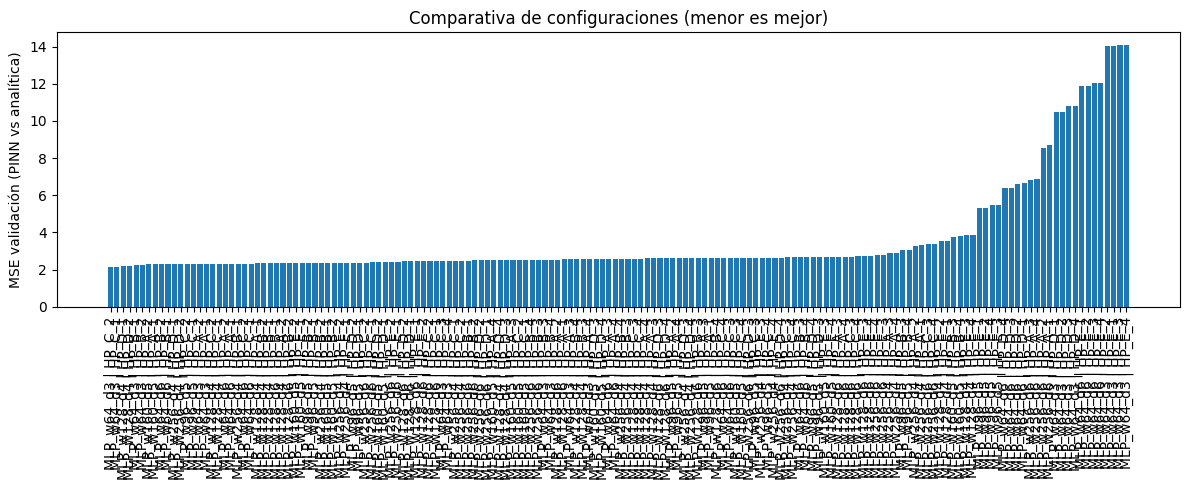

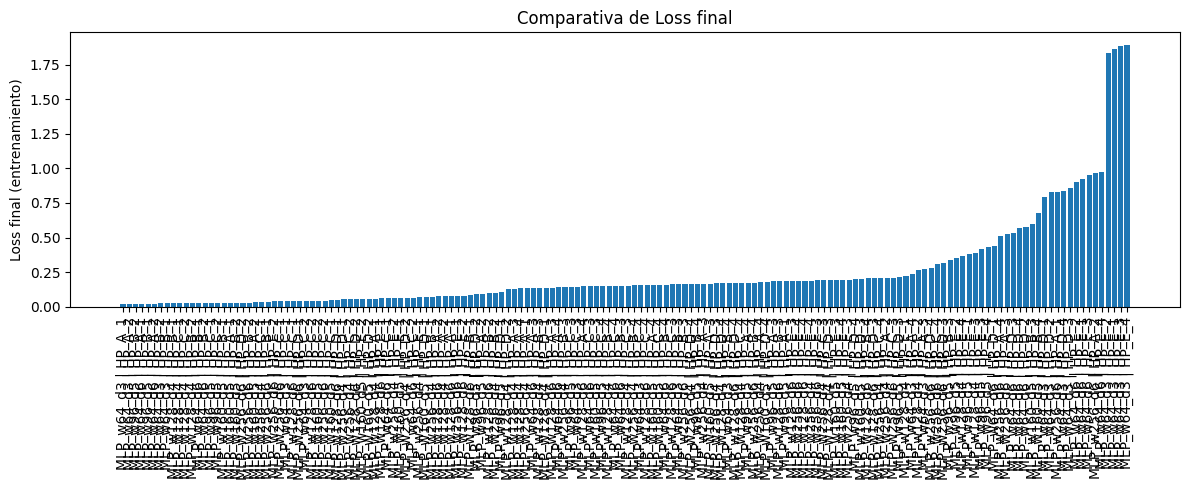

In [18]:
# 7 - GRID SEARCH: gráficas comparativas
# ------------------------------------------------------------
# - Barras de MSE vs analítica por ejecución (ordenadas)
# - Barras de Loss final
# ------------------------------------------------------------
labels = [f"{r['arch']} | {r['hp']}" for r in all_results]
mse_vals = [r["val_mse"] for r in all_results]
order = np.argsort(mse_vals)

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(labels)), np.array(mse_vals)[order])
plt.xticks(np.arange(len(labels)), np.array(labels)[order], rotation=90)
plt.ylabel("MSE validación (PINN vs analítica)")
plt.title("Comparativa de configuraciones (menor es mejor)")
plt.tight_layout()
plt.show()

final_losses = [r["final_loss"] for r in all_results]
order2 = np.argsort(final_losses)

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(labels)), np.array(final_losses)[order2])
plt.xticks(np.arange(len(labels)), np.array(labels)[order2], rotation=90)
plt.ylabel("Loss final (entrenamiento)")
plt.title("Comparativa de Loss final")
plt.tight_layout()
plt.show()


In [19]:
# 8 - SELECCIÓN MEJOR CONFIG + REENTRENAMIENTO CON CHECKPOINTS
# ------------------------------------------------------------
# - Selecciona la mejor por MSE
# - Reentrena guardando checkpoints para animación
# ------------------------------------------------------------
best_row = df_results.iloc[0]
best_arch_name = best_row["arch"]
best_hp_name   = best_row["hp"]
print("Mejor configuración encontrada:")
print(best_row)

# Recuperar specs
arch_best = None
for a in architectures:
    if a["name"] == best_arch_name:
        arch_best = a; break
hp_best = None
for h in hp_grid:
    if h["name"] == best_hp_name:
        hp_best = h; break

# Reentrenar con checkpoints
model_best, ff_best, state_best, history_best, checkpoints_best, mse_best, meta_best = train_run(
    width=arch_best["width"], depth=arch_best["depth"],
    n_harmonics=hp_best["n_harmonics"], use_fourier=True, use_periodicity=hp_best["use_periodicity"],
    lr=hp_best["lr"], epochs=hp_best["epochs"], print_each=hp_best["print_each"],
    n_col=N_COL, n_ic=N_IC, n_pb=N_PB, w_phys=W_PHYS, w_ic=W_IC, w_pb=W_PB, use_lbfgs=hp_best["use_lbfgs"],
    seed=SEED, save_checkpoints=True
)
print("MSE de la mejor config (reentrenada):", mse_best)

best_bundle = {
    "arch": arch_best, "hp": hp_best,
    "state": state_best, "history": history_best,
    "checkpoints": checkpoints_best, "meta": meta_best
}


Mejor configuración encontrada:
arch               MLP_w64_d3
hp                     HP_C_2
val_mse              2.140577
final_loss           0.041949
epochs                   2500
lr                     0.0007
n_harmonics                 4
use_periodicity         False
use_lbfgs                True
width                      64
depth                       3
elapsed_sec         96.010989
Name: 0, dtype: object


Entrenamiento:   0%|          | 0/2500 [00:00<?, ?it/s]

MSE de la mejor config (reentrenada): 2.140576859477866


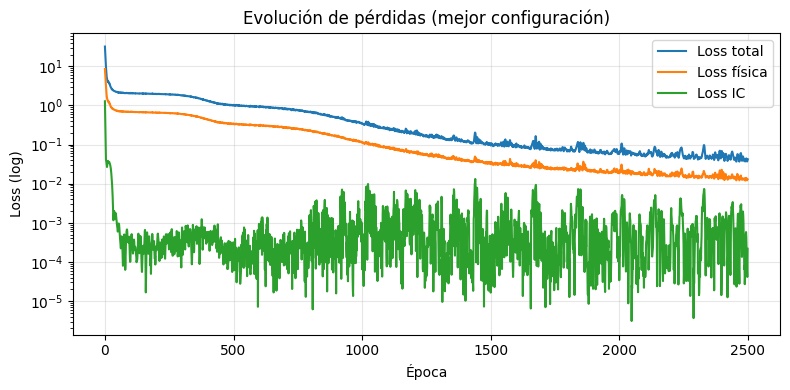

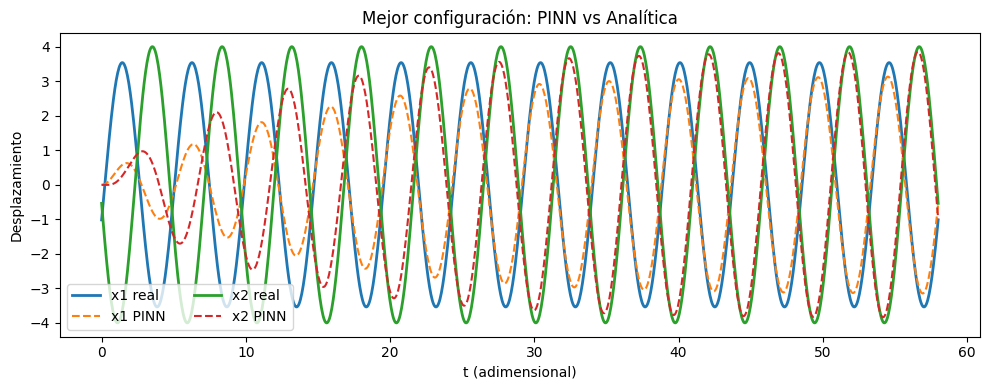

In [20]:
# 9 - GRÁFICAS DE PÉRDIDAS (MEJOR CONFIG) Y COMPARACIÓN CURVAS
# ------------------------------------------------------------
# - Curvas de pérdidas para la mejor configuración
# - Comparación PINN vs analítica (misma rejilla)
# ------------------------------------------------------------
# Pérdidas
plt.figure(figsize=(8,4))
plt.plot(best_bundle["history"]["total"], label="Loss total")
plt.plot(best_bundle["history"]["phys"], label="Loss física")
plt.plot(best_bundle["history"]["ic"],   label="Loss IC")
if best_bundle["hp"]["use_periodicity"]:
    plt.plot(best_bundle["history"]["per"], label="Loss periodicidad")
plt.yscale("log")
plt.xlabel("Época")
plt.ylabel("Loss (log)")
plt.title("Evolución de pérdidas (mejor configuración)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Comparación de curvas finales
t_grid_best = torch.linspace(t_ini, t_fin, N_EVAL, device=device).view(-1,1).requires_grad_(True)
ff_vis = build_ff(P.omega, best_bundle["hp"]["n_harmonics"], True)
n_in_best = 1 + 2*best_bundle["hp"]["n_harmonics"]
model_vis = build_model(n_in_best, width=best_bundle["arch"]["width"], depth=best_bundle["arch"]["depth"])
model_vis.load_state_dict(best_bundle["state"])

with torch.no_grad():
    x_hat_best = model_vis(encode_time(ff_vis, t_grid_best)).detach().cpu().numpy()

t_eval_best = t_grid_best.detach().cpu().numpy().squeeze()
x1r_best, x2r_best = analytic_steady_state(t_eval_best, P.zeta, P.kappa, P.A1, P.A2, P.omega)

plt.figure(figsize=(10,4))
plt.plot(t_eval_best, x1r_best, label="x1 real", linewidth=2)
plt.plot(t_eval_best, x_hat_best[:,0], "--", label="x1 PINN")
plt.plot(t_eval_best, x2r_best, label="x2 real", linewidth=2)
plt.plot(t_eval_best, x_hat_best[:,1], "--", label="x2 PINN")
plt.xlabel("t (adimensional)")
plt.ylabel("Desplazamiento")
plt.title("Mejor configuración: PINN vs Analítica")
plt.legend(ncols=2)
plt.tight_layout()
plt.show()


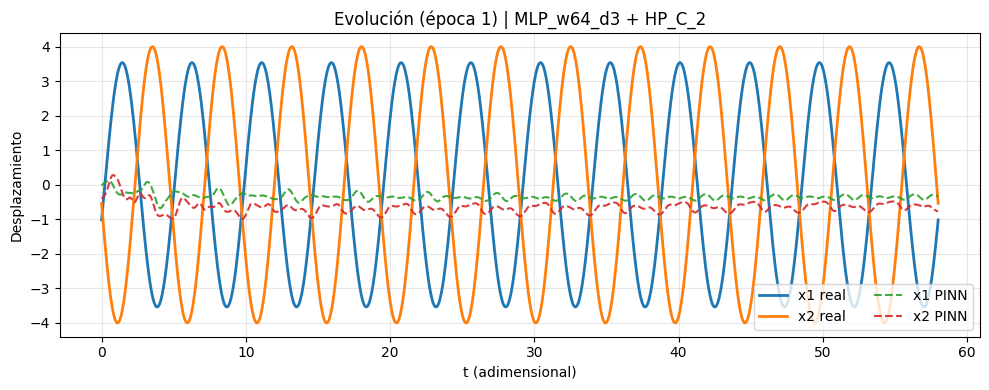

Animación guardada en 'best_pinn_vs_real.gif'


In [21]:
# 10 - ANIMACIÓN: evolución PINN vs datos reales (mejor config)
# ------------------------------------------------------------
# - Usa checkpoints guardados en el reentrenamiento de la mejor config
# - Genera y (opcional) guarda GIF
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,4))
line_real1, = ax.plot(t_eval_best, x1r_best, label="x1 real", linewidth=2)
line_real2, = ax.plot(t_eval_best, x2r_best, label="x2 real", linewidth=2)
line_hat1,  = ax.plot(t_eval_best, best_bundle["checkpoints"][0][1], "--", label="x1 PINN", alpha=0.9)
line_hat2,  = ax.plot(t_eval_best, best_bundle["checkpoints"][0][2], "--", label="x2 PINN", alpha=0.9)
ax.set_xlabel("t (adimensional)")
ax.set_ylabel("Desplazamiento")
ax.set_title(f"Evolución (época {best_bundle['checkpoints'][0][0]}) | {best_bundle['arch']['name']} + {best_bundle['hp']['name']}")
ax.legend(ncols=2)
ax.grid(True, alpha=0.3)

def update(frame_idx):
    ep, x1h, x2h = best_bundle["checkpoints"][frame_idx]
    line_hat1.set_ydata(x1h)
    line_hat2.set_ydata(x2h)
    ax.set_title(f"Evolución (época {ep}) | {best_bundle['arch']['name']} + {best_bundle['hp']['name']}")
    return line_hat1, line_hat2

anim = FuncAnimation(fig, update, frames=len(best_bundle["checkpoints"]), interval=600, blit=False)
plt.tight_layout()
plt.show()

# Guardar GIF (opcional)
try:
    anim.save("best_pinn_vs_real.gif", writer="pillow", fps=2)
    print("Animación guardada en 'best_pinn_vs_real.gif'")
except Exception as e:
    print("No se pudo guardar el GIF (instala 'pillow'). Error:", e)


In [22]:
# 11 - APLICAR LA MEJOR CONFIGURACIÓN AL CONTEXTO GLOBAL
# ------------------------------------------------------------
# - Sobrescribe globals 'model', 'ff', 'N_HARMONICS', 'USE_FOURIER',
#   para reutilizar en posibles celdas posteriores
# ------------------------------------------------------------
USE_FOURIER = True
N_HARMONICS = best_bundle["hp"]["n_harmonics"]
ff = build_ff(P.omega, N_HARMONICS, USE_FOURIER)
n_in = 1 + 2*N_HARMONICS
model = build_model(n_in, width=best_bundle["arch"]["width"], depth=best_bundle["arch"]["depth"])
model.load_state_dict(best_bundle["state"])
print("Mejor arquitectura:", best_bundle["arch"])
print("Mejores hiperparámetros:", best_bundle["hp"])


Mejor arquitectura: {'name': 'MLP_w64_d3', 'width': 64, 'depth': 3}
Mejores hiperparámetros: {'name': 'HP_C_2', 'lr': 0.0007, 'epochs': 2500, 'n_harmonics': 4, 'use_periodicity': False, 'use_lbfgs': True, 'print_each': 500}
